# High Level Steps

0. Create env and install deps (Or not, no packages used. Pure builtins)
1. Populate databases (Can turn this on/off using arg of ``--reset_db true/false``)
2. Run Apriori (Set arg of ``--support [int] as well as --confidence [float]``)
3. Run Brute Force (Set arg of ``--support [int] as well as --confidence [float]``)
4. Compare results (In notebook script, some cells will output results to a file)

Running the main.py file will do all of this for you.
Running cells below will also do it via interactive notebook.

# Requirements:
1. Values Read in from db
    - Using sqlite3 databases and resetting them every run. Populating the dbs with random transactions prior to starting any processing, then reading in from them via a SELECT * query.
    The cli version and notebook also offer ways to avoid resetting the db as well and offer it as a convenience to turn on/off.

2. Support & Confidence are user defined at runtime.
    - Both this notebook and script version take user input in the form of the ``input`` function or using ``argparse`` respectively. No hardcoding.

3. Brute force stops early when no frequent itemsets found.
    - See lines 57-59 in ``brute.py`` for the cli version or the cell below in the ``Brute.get_association_rules()`` function for reference of this. Output will also confirm no more supersets/itemsets are calculated once none are found.

4. Brute force and Apriori both calculate same rules.
    - Checks at the end compare if output rules match exactly. Errors out if not

5. Timing is calculated.
    - Time is shown for both the implementations as well as the difference where apriori is faster in almost every iteration.

# ToC
- databases/
    - This directory stores the sqllite databases. Creating DBs manually is supported assuming they adhear to the following schema. 
        - id: primary_key -- Auto Incremented
        - items: varchar -- Comma delimited list of items (eg. eggs,milk,butter...)
        - price: number -- Cost of entire transaction

- rules/
    - This directory store the rules when run via notebook. These will be the output of all databases across both implementations. While both the ``database_n_rules_[brute/apriori].json`` will be identical, they will still be created for completeness. (Only generated when run via notebook)

- tests/
    - Just a couple of sanity checks as I was developing, can most likely ignore.

- apriori.py
    - The Apriori association rule implementation.
    
- brute.py
    - The Brute Force association rule implementation.
        
- db.py
    - All code related to the database resetting, reading and writing to them

- main.py
    - The main entrypoint that takes in arguments, potentially resets db, and runs both algos with timing and comparison.

- submission.ipynb
    - Interactive Notebook which will serve to show some outputs as well as export to a pdf for the submission. Contains the source code, execution as well as some notes.

## First we set out params, in script these are input args

In [1]:
SUPPORT = int(input("Enter Support Threshold Value: "))
CONFIDENCE = float(input("Enter Confidence Threshold Value: "))
RESET_DB = False
if input("Reset the DB with new mock data? (Must be done if no dbs exist [y/n]): ") == "y":
    RESET_DB = True

ITEMS_PER_TRANSACTION_MIN = 10
ITEMS_PER_TRANSACTION_MAX = 20 # Be careful with this, brute takes forever at high values
print(SUPPORT)
print(CONFIDENCE)

8
0.6


## Define some database stuff to make it rerunnable

In [2]:
import json
import logging
import random
import shutil
import sqlite3
import timeit

from itertools import combinations
from pathlib import Path
from sqlite3 import Connection
from typing import Union


logging.basicConfig(level=logging.INFO, format="%(name)s - %(message)s")

logger = logging.getLogger(__name__)

DAIRY = 'dairy'
VEGETABLE = 'vegetable'
BAKERY = 'bakery'
FRUIT = 'fruit'
ITEMS = [
    {
        "title": "Brown eggs",
        "type": DAIRY,
        "price": 28.1,
    },
    {
        "title": "Sweet fresh stawberry",
        "type": FRUIT,
        "price": 29.45,
    },
    {
        "title": "Asparagus",
        "type": VEGETABLE,
        "price": 18.95,
    },
    {
        "title": "Green smoothie",
        "type": DAIRY,
        "price": 17.68,
    },
    {
        "title": "Raw legums",
        "type": VEGETABLE,
        "price": 17.11,
    },
    {
        "title": "Cake",
        "type": DAIRY,
        "price": 11.14,
    },
    {
        "title": "Pesto with basil",
        "type": VEGETABLE,
        "price": 18.19,
    },
    {
        "title": "Hazelnut",
        "type": VEGETABLE,
        "price": 27.35,
    },
    {
        "title": "Lemon",
        "type": FRUIT,
        "price": 15.79,
    },
    {
        "title": "Bread",
        "type": BAKERY,
        "price": 17.48,
    },
    {
        "title": "Legums",
        "type": VEGETABLE,
        "price": 14.77,
    },
    {
        "title": "Fresh tomato",
        "type": VEGETABLE,
        "price": 16.3,
    },
    {
        "title": "Oatmeal",
        "type": FRUIT,
        "price": 13.02,
    },
    {
        "title": "Green beans",
        "type": VEGETABLE,
        "price": 28.79,
    },
    {
        "title": "Portabello mushrooms",
        "type": BAKERY,
        "price": 20.31,
    },
    {
        "title": "Strawberry jelly",
        "type": FRUIT,
        "price": 14.18,
    },
    {
        "title": "Pear juice",
        "type": FRUIT,
        "price": 19.49,
    },
    {
        "title": "Fresh pears",
        "type": FRUIT,
        "price": 15.12,
    },
    {
        "title": "Salad",
        "type": VEGETABLE,
        "price": 16.76,
    },
    {
        "title": "Oranges",
        "type": FRUIT,
        "price": 21.48,
    },
    {
        "title": "Cremini Mushrooms",
        "type": DAIRY,
        "price": 22.7,
    },
    {
        "title": "Honey",
        "type": BAKERY,
        "price": 17.01,
    },
    {
        "title": "Cottage Cheese",
        "type": FRUIT,
        "price": 14.05,
    },
    {
        "title": "Mint",
        "type": FRUIT,
        "price": 26.21,
    },
    {
        "title": "Ricotta",
        "type": DAIRY,
        "price": 27.81,
    },
    {
        "title": "Granola",
        "type": DAIRY,
        "price": 29.97,
    },
    {
        "title": "Chia seeds",
        "type": FRUIT,
        "price": 25.26,
    },
    {
        "title": "Yogurt",
        "type": DAIRY,
        "price": 27.61,
    },
    {
        "title": "Sandwich",
        "type": VEGETABLE,
        "price": 22.48,
    },
    {
        "title": "Cherry",
        "type": FRUIT,
        "price": 14.35,
    },
]

#####################################################
################### DATABASES #######################
#####################################################
DB_DIR = f"{Path().parent.resolve()}/databases"


def connect(db: str):
    """create a database connection to a SQLite database"""
    Path(DB_DIR).mkdir(exist_ok=True)
    fq_path = Path(DB_DIR, f"{db}.sqlite3")
    if fq_path.exists():
        logger.info(f"Connecting to DB @ {fq_path}")
    else:
        logger.info(f"Creating DB @ {fq_path}")
    conn = sqlite3.connect(fq_path)
    return conn


def populate(conn: Connection):
    """Populates a db with some name"""
    table_name = "transactions"
    sql = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            id integer PRIMARY KEY,
            items text NOT NULL,
            price number
        );
    """
    conn.execute(sql)

    # Generate 20 random samples and save as a transaction
    num_transactions = 20
    for _ in range(num_transactions):
        sample = random.sample(ITEMS, random.randint(ITEMS_PER_TRANSACTION_MIN, ITEMS_PER_TRANSACTION_MAX))
        items = ",".join([x["title"] for x in sample])
        price = sum([x["price"] for x in sample])
        insert = f"""
            INSERT INTO {table_name}(items,price)
            VALUES(?,?)
        """
        cur = conn.cursor()
        cur.execute(insert, (items, price))
        conn.commit()

def reset_db():
    # Reset the DBs every time
    shutil.rmtree(DB_DIR, ignore_errors=True)

    for i in range(1, 6):
        # Create 5 transaction dbs
        db_name = f"transactions_{i}"
        conn = connect(db_name)
        populate(conn)
        logger.info(f"Populated {db_name} with random transaction data\n")

    logger.info("Databases Reset :)\nReady to begin...")

if RESET_DB:
    # Do the thing
    reset_db()

__main__ - Creating DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_1.sqlite3
__main__ - Populated transactions_1 with random transaction data

__main__ - Creating DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_2.sqlite3
__main__ - Populated transactions_2 with random transaction data

__main__ - Creating DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_3.sqlite3
__main__ - Populated transactions_3 with random transaction data

__main__ - Creating DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_4.sqlite3
__main__ - Populated transactions_4 with random transaction data

__main__ - Creating DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_5.sqlite3
__main__ - Populated transactions_5 with random transaction data

__main__ - Databases Reset :)
Ready to begin...


# Our Brute force algo

In [3]:
brute_logger = logging.getLogger("brute")

class Brute:

    def __init__(
        self,
        transactions: list,
        support: Union[int, float],
        confidence: float
    ) -> None:
        
        # If % support given, calculate it, else use int
        if isinstance(support, float):
            support = len(transactions) * support
        self.min_support_count = support
        self.confidence = confidence
        # Hold initial transactions
        self.transactions = [set(x["items"]) for x in transactions]
        # [["apples", "oranges"], ["oranges", ..., "kiwi"], [...], ...]

        # Largest possible itemset
        self.max_k = max([len(x) for x in self.transactions])

        # Get initial counts of all items (first step)
        initial_counts = {}
        for transaction in self.transactions:
            for item in transaction:
                if item in initial_counts:
                    initial_counts[item] += 1
                else:
                    initial_counts[item] = 1
        self.initial_counts = initial_counts

    def get_association_rules(self):
        """ Start by finid """

        all_items = [x["title"] for x in ITEMS]
        brute_logger.debug(f"Len of items: {len(all_items)}")
        # Start by generating all possible itemsets
        all_frequent = []
        for k in range(2, self.max_k+1):
            # Get all itemsets for k
            k_combs = {x for x in combinations(all_items, k)}
            
            # Sanity check
            if k==2:
                assert len(k_combs)==435

            frequent = [itemset for itemset in k_combs if self.is_frequent(itemset)]
            brute_logger.debug(f"Found {len(frequent)} of {len(k_combs)} {k}-itemsets total combinations to be frequent")
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # EARLY STOPPING MECHINISM
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            if len(frequent)==0:
                brute_logger.info(f"EARLY STOP - No frequent {k}-itemsets found, not going higher")
                break

            all_frequent.extend(list(frequent))
        
        # Caclulate confidence of each potential rule
        all_subsets = {}
        for itemset in all_frequent:
            subsets = []
            for i in range(len(itemset)-1, 0, -1):
                subsets.extend(list(combinations(itemset, i)))
            all_subsets["|".join(itemset)] = {
                "subsets": subsets,
                "items": itemset,
            }

        rules = []
        for itemset_string, itemset_vals in all_subsets.items():
            subs = itemset_vals["subsets"]
            ind_items = set(itemset_vals["items"])
            for sub in subs:
                sub = set(sub)
                left = ind_items.difference(sub)
                rule = f"[{'^'.join(sub)}]=>[{'^'.join(left)}]"
                conf = self.calc_support(ind_items)/self.calc_support(sub)
                if conf>=self.confidence:
                    rules.append({
                        "rule": rule,
                        "items_bought": list(sub),
                        "implies": list(left),
                        "confidence": f"{round(conf*100,2)}%"
                    })
        brute_logger.debug(f"Number of rules Found: {len(rules)}")
        
        return rules

    def is_frequent(self, itemset: set) -> bool:
        if self.calc_support(itemset)>=self.min_support_count:
            return True
        return False
    
    def calc_support(self, itemset: set):
        count = 0
        itemset = set(itemset)
        for transaction in self.transactions:
            # If this itemset is not in a transaction, skip
            if not itemset.issubset(transaction):
                continue
            count+=1
        return count


## Our Apriori Algo

In [4]:
ap_logger = logging.getLogger("apriori")

# Quick and dirty hashing
SPLIT_CHAR = "|"

class Apriori:

    def __init__(
        self,
        transactions: list,
        support: Union[int, float],
        confidence: float
    ) -> None:

        # If % support given, calculate it, else use int
        if isinstance(support, float):
            support = len(transactions) * support
        self.min_support_count = support
        self.confidence = confidence

        # Hold initial transactions
        self.transactions = [set(x["items"]) for x in transactions]
        # [["apples", "oranges"], ["oranges", ..., "kiwi"], [...], ...]

        # Get initial counts of all items (first step)
        initial_counts = {}
        for transaction in self.transactions:
            for item in transaction:
                if item in initial_counts:
                    initial_counts[item] += 1
                else:
                    initial_counts[item] = 1
        self.initial_counts = initial_counts

        # Store the freq itemsets
        self.freq_itemsets = None

    def calc_support(self, itemset):
        count = 0
        itemset = set(itemset)
        for transaction in self.transactions:
            # If this itemset is not in a transaction, skip
            if not itemset.issubset(transaction):
                continue
            count+=1
        return count

    def get_association_rules(self):

        self.freq_itemsets = self.get_freq_itemsets()
        items = [list(x.split(SPLIT_CHAR)) for x in self.freq_itemsets.keys()]

        # Calculate all subsets for each itemset
        all_subsets = {}
        for itemset in items:
            subsets = []
            for i in range(len(itemset)-1, 0, -1):
                combs = list(combinations(itemset, i))
                subsets.extend(combs)
            all_subsets[SPLIT_CHAR.join(itemset)] = {
                "subsets": subsets,
                "items": itemset,
            }

        ap_logger.debug(f"\nSubsets of freq itemsets: {all_subsets}")
        # Apply rules and use the confidence
        rules = []
        for itemset_string, itemset_vals in all_subsets.items():
            subs = itemset_vals["subsets"]
            ind_items = set(itemset_vals["items"])
            for sub in subs:
                sub = set(sub)
                left = ind_items.difference(sub)
                rule = f"[{'^'.join(sub)}]=>[{'^'.join(left)}]"
                conf = self.calc_support(ind_items)/self.calc_support(sub)
                if conf>=self.confidence:
                    rules.append({
                        "rule": rule,
                        "items_bought": list(sub),
                        "implies": list(left),
                        "confidence": f"{round(conf*100,2)}%"
                    })
        ap_logger.debug(f"Number of rules Found: {len(rules)}")
        return rules
    
    def get_freq_itemsets(self):

        # Prune initial counts
        pruned = {
            item: count
            for item, count
            in self.initial_counts.items()
            if count >= self.min_support_count
        }

        # This will hold most recent pruned and only update if more itemsets found
        all_pruned = {} 
        all_pruned.update(pruned)
        k = 2
        while True:
            last_pruned = pruned
            pruned = self._step(k=k, pruned=pruned)
            all_pruned.update(pruned)
            k+=1
            if not pruned:
                break
        ap_logger.debug(f"\nFound frequent itemsets: {last_pruned}")
        return all_pruned

    def _step(self, k: int, pruned: dict):
        """The iteritive step of joining and pruning where k is the k-th itemset

        Args:
            k (int): Value of k-itemset
        """
        ap_logger.debug(f"\nPruned: {pruned}")
        # Form new itemset from pruned
        items_left = []
        for items in pruned.keys():
            items_left.extend(items.split(SPLIT_CHAR))
        items_left = set(items_left)

        # Form k-itemset
        combs = [set(x) for x  in combinations(items_left, k)]

        # Count if itemsets are in transactions
        counts = {}
        for itemset in combs:
            itemset_name = SPLIT_CHAR.join(itemset)
            for transaction in self.transactions:
                # If this itemset is not in a transaction, skip
                if not itemset.issubset(transaction):
                    continue

                # Add the support count if found
                if itemset_name in counts:
                    counts[itemset_name] += 1
                else:
                    counts[itemset_name] = 1

        # Remove those under support count
        pruned = {
            itemset: count
            for itemset, count
            in counts.items()
            if count >= self.min_support_count
        }
        return pruned

In [6]:
logger = logging.getLogger("main")

if __name__=="__main__":

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # READING IN DATA FROM A DATABASE
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    db_data = [
        connect(f"transactions_{i}").cursor().execute("SELECT * FROM transactions;").fetchall()
        for i
        in range(1, 6)
    ]
    # Convert to a dict
    all_transactions = []
    for data in db_data:
        db_transactions = []
        for row in data:
            db_transactions.append(
                {
                    "id": row[0],
                    "items": row[1].split(","),
                    "price": row[2],
                }
            )
        all_transactions.append(db_transactions)

    # APRIORI LOOP
    start = timeit.default_timer()
    all_ap_rules = {}
    for i in range(5):
        transactions = all_transactions[i]
        logger.info("--------------------------------------")
        logger.info(f"--------- APRIORI FOR DB {i+1}------------")
        logger.info("--------------------------------------")
        logger.info(f"Printing only first transcation for brevity: {json.dumps(transactions[0], indent=4)}")

        ap = Apriori(
            transactions=transactions,
            support=SUPPORT,
            confidence=CONFIDENCE
        )
        apriori_rules = ap.get_association_rules()
        logger.info(f"Found {len(apriori_rules)} rules using Apriori on DB {i+1}")
        logger.info(f"Printing only one rule for brevity: {json.dumps(apriori_rules[-1], indent=4)}")
        all_ap_rules[f"database_{i+1}"] = apriori_rules


    apriori_time = timeit.default_timer()-start
    logger.info(f"Apriori Algo Time: {apriori_time}")


    # BRUTE LOOP
    start = timeit.default_timer()
    all_brute_rules = {}
    for i in range(5):
        transactions = all_transactions[i]
        logger.info("--------------------------------------")
        logger.info(f"--------- BRUTE FOR DB {i+1}------------")
        logger.info("--------------------------------------")
        logger.info(f"Printing only first transcation for brevity: {json.dumps(transactions[0], indent=4)}")

        brute = Brute(
            transactions=transactions,
            support=SUPPORT,
            confidence=CONFIDENCE
        )
        brute_rules = brute.get_association_rules()
        
        logger.info(f"Found {len(brute_rules)} rules using Brute on DB {i+1}")
        logger.info(f"Printing only one rule for brevity: {json.dumps(brute_rules[-1], indent=4)}")
        all_brute_rules[f"database_{i+1}"] = brute_rules


    # Sort both rules

    brute_time = timeit.default_timer()-start
    logger.info(f"Brute Force Time: {brute_time}")

    # Recreate rules folder every time and write out
    output_dir = f"{Path().parent.resolve()}/rules"
    shutil.rmtree(output_dir, ignore_errors=True)
    Path(output_dir).mkdir(exist_ok=True)

    # Sort rules to make sure they are the same
    for i in range(1, 6):
        db_ap_rules = all_ap_rules[f"database_{i}"]
        db_brute_rules = all_brute_rules[f"database_{i}"]
        if len(db_ap_rules)==len(db_brute_rules):
            logger.info(f"Rules for Apriori and Brute in DB {i} matched and found {len(db_brute_rules)} rules")

        # Write out files
        fq_path_ap = Path(output_dir, f"database_{i}_rules_apriori.json")
        fq_path_br = Path(output_dir, f"database_{i}_rules_brute.json")
        with open(fq_path_ap, "w") as fh:
            json.dump(db_ap_rules, fh)
        with open(fq_path_br, "w") as fh:
            json.dump(db_brute_rules, fh)
        logger.info(f"Rules written out to path: {output_dir}")

    logger.info(f"Over entire execution Apriori was {round((-1)*(apriori_time-brute_time),5)} seconds faster")



main - Connecting to DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_1.sqlite3
main - Connecting to DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_2.sqlite3
main - Connecting to DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_3.sqlite3
main - Connecting to DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_4.sqlite3
main - Connecting to DB @ C:\Users\Matt\Documents\GitHub\dm_midterm\databases\transactions_5.sqlite3
main - --------------------------------------
main - --------- APRIORI FOR DB 1------------
main - --------------------------------------
main - Printing only first transcation for brevity: {
    "id": 1,
    "items": [
        "Strawberry jelly",
        "Chia seeds",
        "Cherry",
        "Pear juice",
        "Bread",
        "Ricotta",
        "Cremini Mushrooms",
        "Fresh tomato",
        "Yogurt",
        "Fresh pears",
        "Raw legums",
        "Legums",
        "Cake",

## View some of the rules output
#### Read from the newly created rules/ directory

In [10]:
with open(output_dir+"/database_1_rules_apriori.json", "r") as fh:
    rules = json.load(fh)

rule1, rule2, rule3 = rules[0], rules[int((len(rules)-1)/2)], rules[len(rules)-1]
ap_rules = [rule1, rule2, rule3]
print(json.dumps(rule1, indent=4))
print(json.dumps(rule2, indent=4))
print(json.dumps(rule3, indent=4))

{
    "rule": "[Fresh pears]=>[Portabello mushrooms]",
    "items_bought": [
        "Fresh pears"
    ],
    "implies": [
        "Portabello mushrooms"
    ],
    "confidence": "72.73%"
}
{
    "rule": "[Oatmeal]=>[Legums]",
    "items_bought": [
        "Oatmeal"
    ],
    "implies": [
        "Legums"
    ],
    "confidence": "80.0%"
}
{
    "rule": "[Fresh tomato]=>[Strawberry jelly]",
    "items_bought": [
        "Fresh tomato"
    ],
    "implies": [
        "Strawberry jelly"
    ],
    "confidence": "72.73%"
}


In [11]:
with open(output_dir+"/database_1_rules_brute.json", "r") as fh:
    brute_rules = json.load(fh)

for ap_rule in ap_rules:
    for brute_rule in rules:
        if ap_rule["rule"]==brute_rule["rule"]:
            print("Matching Brute Rule for above Apriori Rule")
            print(brute_rule)

Matching Brute Rule for above Apriori Rule
{'rule': '[Fresh pears]=>[Portabello mushrooms]', 'items_bought': ['Fresh pears'], 'implies': ['Portabello mushrooms'], 'confidence': '72.73%'}
Matching Brute Rule for above Apriori Rule
{'rule': '[Oatmeal]=>[Legums]', 'items_bought': ['Oatmeal'], 'implies': ['Legums'], 'confidence': '80.0%'}
Matching Brute Rule for above Apriori Rule
{'rule': '[Fresh tomato]=>[Strawberry jelly]', 'items_bought': ['Fresh tomato'], 'implies': ['Strawberry jelly'], 'confidence': '72.73%'}


# Can also run via CLI if we wanted

In [5]:
!python main.py --support 6 --confidence 0.70

main - Using user supplied confidence of 0.7
main - Using user supplied support of 6
main - --------------------------------------
main - --------- APRIORI FOR DB 1------------
main - --------------------------------------
main - Printing only first transcation for brevity: {
    "id": 1,
    "items": [
        "Strawberry jelly",
        "Chia seeds",
        "Cherry",
        "Pear juice",
        "Bread",
        "Ricotta",
        "Cremini Mushrooms",
        "Fresh tomato",
        "Yogurt",
        "Fresh pears",
        "Raw legums",
        "Legums",
        "Cake",
        "Portabello mushrooms",
        "Salad",
        "Pesto with basil"
    ],
    "price": 298.58000000000004
}
apriori - Number of Rules Found: 206
main - --------------------------------------
main - --------- APRIORI FOR DB 2------------
main - --------------------------------------
main - Printing only first transcation for brevity: {
    "id": 1,
    "items": [
        "Cake",
        "Sandwich",
        "

## Following is a screenshot of the source code, created databased, rules output, and timings
### This is the same code as above, this notebook was refactored from the source to be more readble

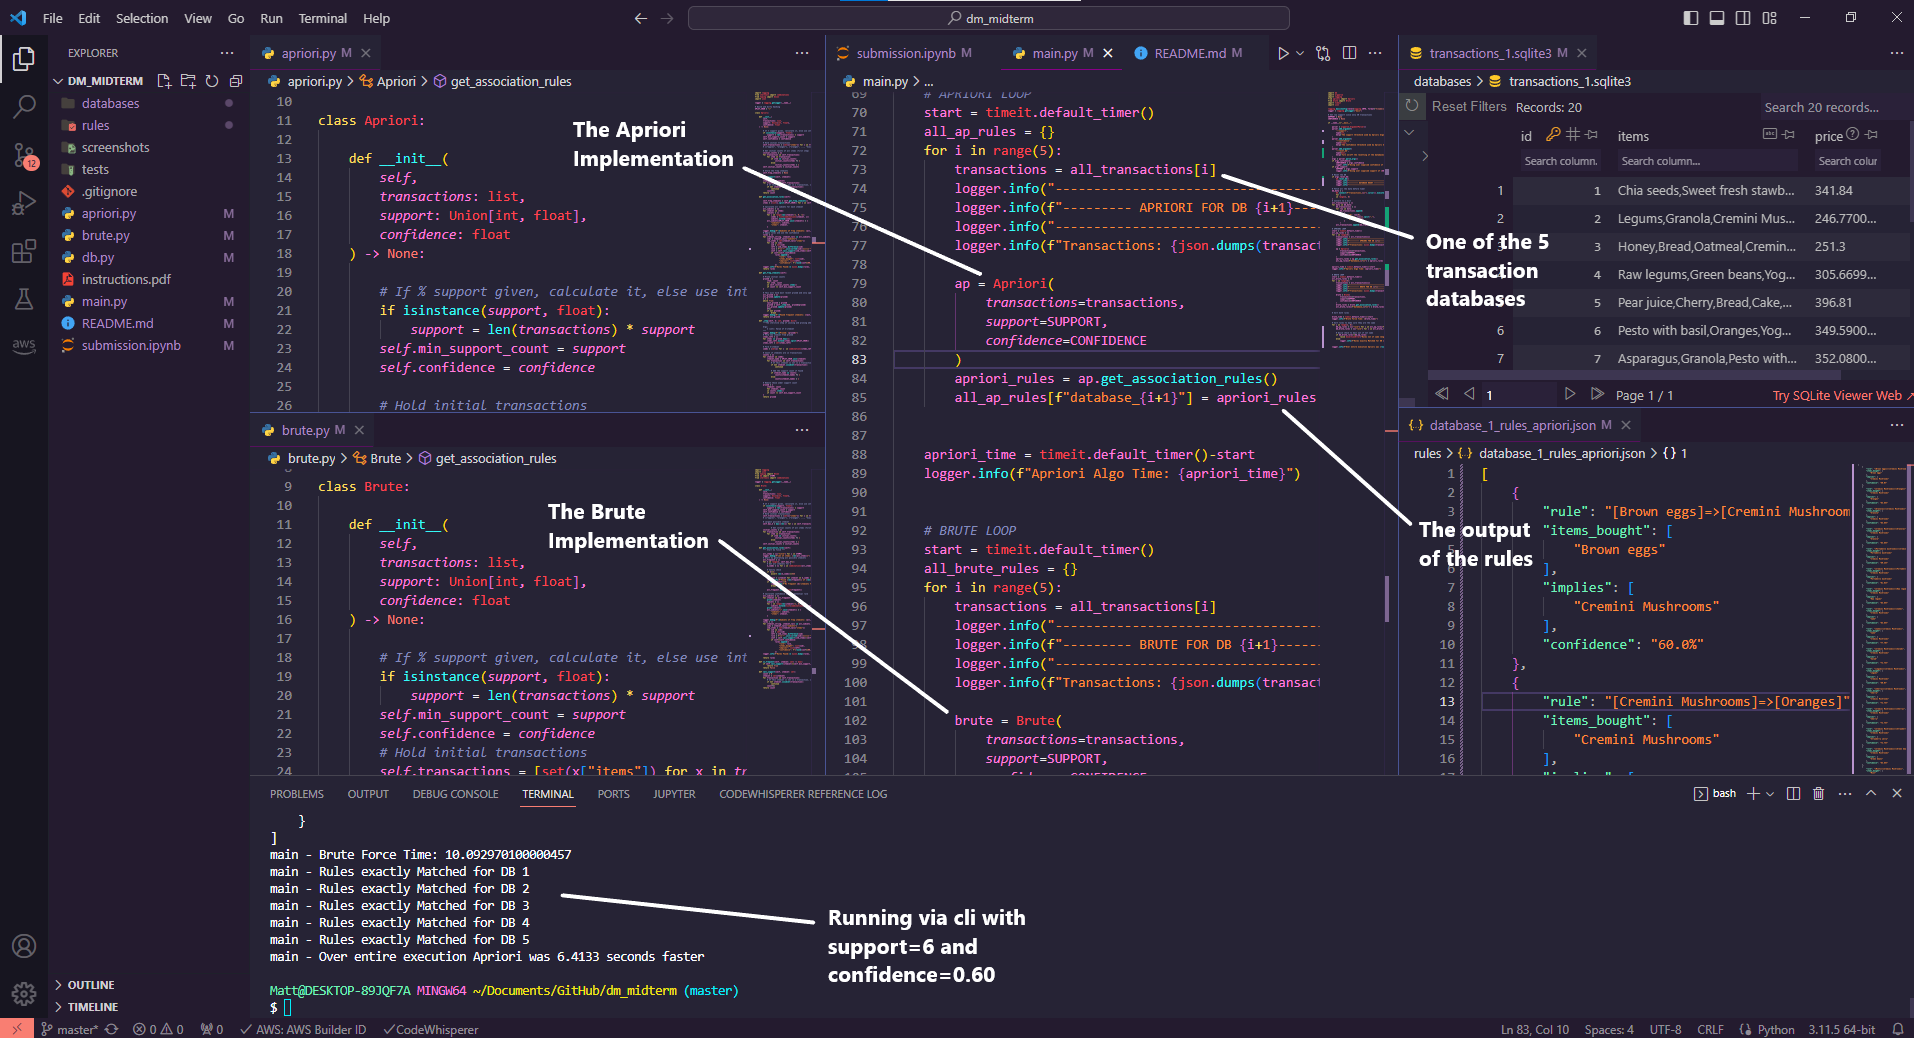

In [2]:
from IPython.display import Image
Image("screenshots/Important_modules.png")